# FateCompass potential mode - simulated data generated using dyngen

This is an example of the application of FateCompass to a ground truth single-cell RNA sequencing dataset. 

In this dataset there are 1000 cells and 1035 genes, from which 130 are transcription factors; also, there is an underlying gene regulatory network provided by the model. See [here](https://doi.org/10.1038/s41467-021-24152-2) for more details. 

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import scanpy.external as sce
import scvelo as scv
import cellrank as cr
import matplotlib.pyplot as plt

In [2]:
scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

%matplotlib inline

### Load data 

1. Annotated AnnData object --> the simulated data comes already pre-procced. 

In [3]:
adata = scv.read('data/simulated_data_dyngen/simulated_data_dyngen.h5ad', cache=True)
adata

AnnData object with n_obs × n_vars = 1000 × 1035
    obs: 'step_ix', 'simulation_i', 'sim_time', 'clusters'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein'
    uns: 'clusters_colors', 'regulatory_network', 'regulatory_network_regulators', 'regulatory_network_targets', 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions'
    obsm: 'X_pca', 'dimred', 'regulatory_network_sc'
    layers: 'counts_protein', 'logcounts', 'spliced', 'unspliced'

2. Binding site matrix 

In [4]:
bs = pd.read_csv('data/simulated_data_dyngen/grn_dyngen.txt', sep='\t',header=0,index_col=0)
bs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1035 entries, Burn1-TF1 to HK500
Columns: 130 entries, Burn1-TF1 to HK5
dtypes: float64(130)
memory usage: 1.0+ MB


In [ ]:
sc.tl.rank_genes_groups(adata,groupby='clusters',method='wilcoxon',tie_correct=True)
sc.tl.filter_rank_genes_groups(adata, groupby='clusters')

In [ ]:
sc.pl.rank_genes_groups_dotplot(adata,groupby='clusters')

### Pre-proccessing

In [5]:
scv.pp.filter_and_normalize(adata)
sc.tl.pca(adata)

Normalized count data: X, spliced, unspliced.


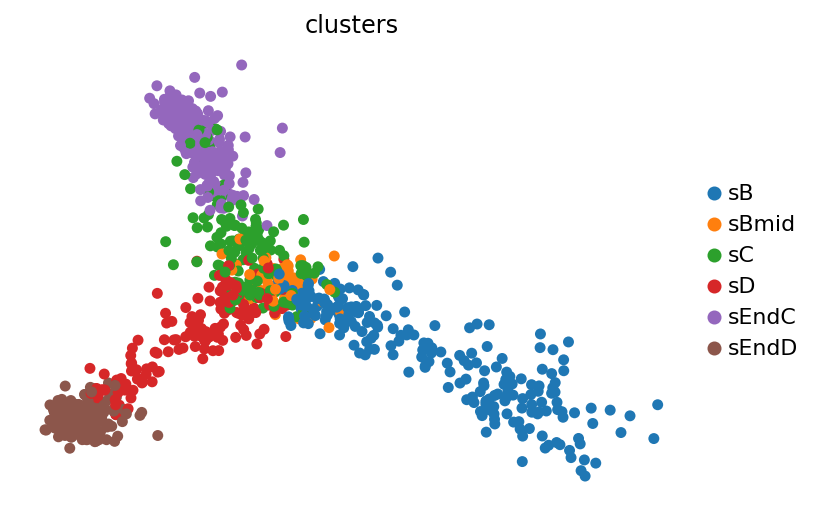

In [6]:
sc.pl.embedding(adata, basis='pca', color=['clusters'],frameon=False)

In [ ]:
# explore the expression of a gene 
sc.pl.embedding(adata, basis='pca', color=['C5-TF1','D6-TF1','Target62'],frameon=False)

### Nearest neighbor graph representing the phenotypic manifold

The **FateCompass** function `graph_fatecompass` builds a nearest neighbor graph in a reduced space.  
For more detailed information about the graph, follow the **advanced mode tutorial**.  

The inputs for the `graph_fatecompass` function are:  
1. **adata**: pre-proccessed and log normalized anndata object. 
2. **mode**: which drift will you use for the transition probabilities. In this notebook we used **'potential'**.
3. **basis**: dimensionality reduction method to compute the nearest neighbor graph.
4. **components**: number of components to compute the nearest neighbor graph. 
5. **n_neighbors**: number of nearest neighbors.  

The output is the neighbor graph ('distances_fatecompass' and 'indices_fatecompass') stored in the anndata object: `adata.obsm`.

In [7]:
mode = 'potential'
basis = 'pca'
components = 2
n_neighbors = 30

In [8]:
from fatecompass import graph_fatecompass

graph_fatecompass(adata, mode, basis, components, n_neighbors)


Computing dimensions in reduced space


Finished -->added
 'indices_fatecompass', knn graph (adata.obsm)



### Prior biological knowledge on progenitor cells and final fates 

The differentiation potential way for inferring dynamics relies on prior biological knowledge about the initial and final fates. This could be provided to the **FateCompass** function `diff_potential_driven_stochastic_simulations` in **three different flavors**; the flavor is specified to the function via the `mode` parameter. In this example we will use the mode `cell_types`.


In [9]:
mode = 'marker_genes'#'cell_types'
initial_fate = 'Target62'#'sB'
end_fates = ['C5-TF1','D6-TF1']#['sEndC','sEndD']

### Cell-fate decision dynamics using differentiation potential as direction of differentiation

The **FateCompass** function `diff_potential_driven_stochastic_simulations` infers transition probabilities using a Markov process on a network, limiting the transitions to the observable states (cells). Then, using the transition probabilities, the **FateCompass** function `diff_potential_driven_stochastic_simulations` performs stochastic simulations using a Monte Carlo sampling algorithm.  

The inputs for the `rna_velocity_driven_stochastic_simulations` function are:  
1. **adata**: pre-proccessed and log normalized anndata object.  
2. **cell_types_key**: key of the observations clustering to consider.  
3. **mode**: way for providing prior biological knowledge.  
4. **initial_fate**: information about the initial fate, it'll depend on the selected `mode`. It can be `['name_initial_cell_type']`, `['marker_gene_initial_cell_type']`, or `[]`.  
5. **end_fates**: information about the final fate, it'll depend on the selected `mode`. It can be `['name_final_cell_type_1',...]`, `['marker_gene_final_cell_type_1',...]`, or `[]`.  
6. **numiter**: number of iterations for the Monte Carlo sampling algortihm. Default: 2000.
7. **numsimcells**: number of trajectories to simulate. Default: 1000.  

The output are the differentiation trajectories ('states' and 'num_trajectories') stored in the anndata object: `adata.uns`, and the differentiation potential also stored in the anndata object: `adata.obs['potential']`.  

In [10]:
from fatecompass import diff_potential_driven_stochastic_simulations

diff_potential_driven_stochastic_simulations(adata, cell_types_key='clusters', mode=mode, 
                                             initial_fate=initial_fate, end_fates=end_fates, 
                                             numiter=1000, numsimcells=1000)


*****Differentiation potential successfully computed.*****


'potential', differentiation potential gradient (adata.obs)


*****Performing stochastic simulations.*****

sim cell	 0
sim cell	 100
sim cell	 200
sim cell	 300
sim cell	 400
sim cell	 500
sim cell	 600
sim cell	 700
sim cell	 800
sim cell	 900

Finished -->added
 'states' and 'num_trajectories', stochastic trajectories (adata.uns)



In [11]:
adata.uns['num_trajectories']

{'sB': 1, 'sBmid': 6, 'sC': 62, 'sD': 86, 'sEndC': 639, 'sEndD': 206}

In [12]:
sc.set_figure_params(scanpy=True, fontsize=16)

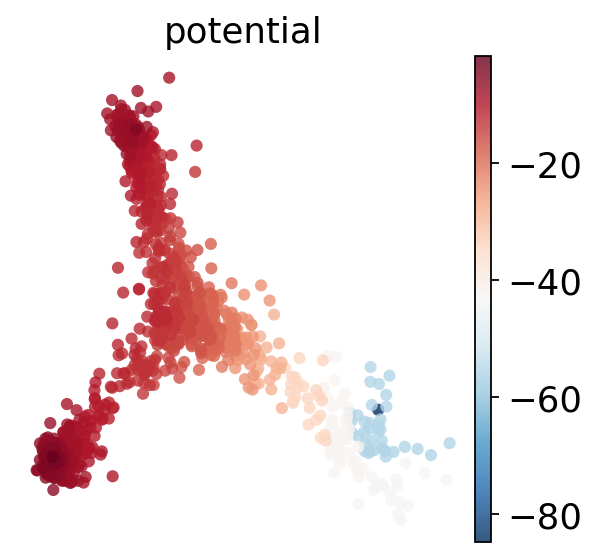

In [13]:
sc.pl.embedding(adata, basis='pca', color=['potential'],frameon=False,cmap='RdBu_r',alpha=0.8)

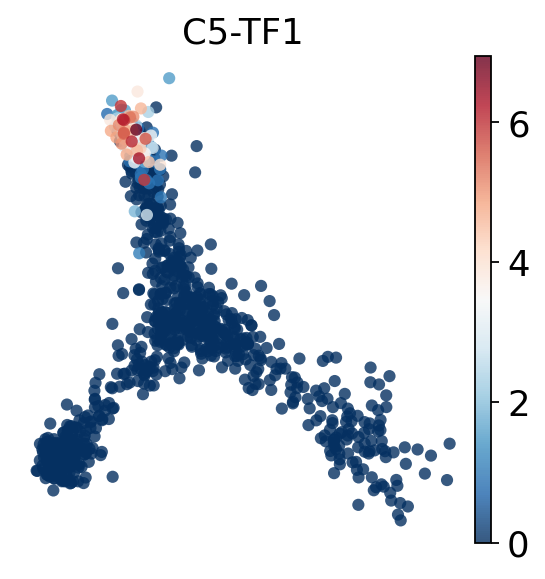

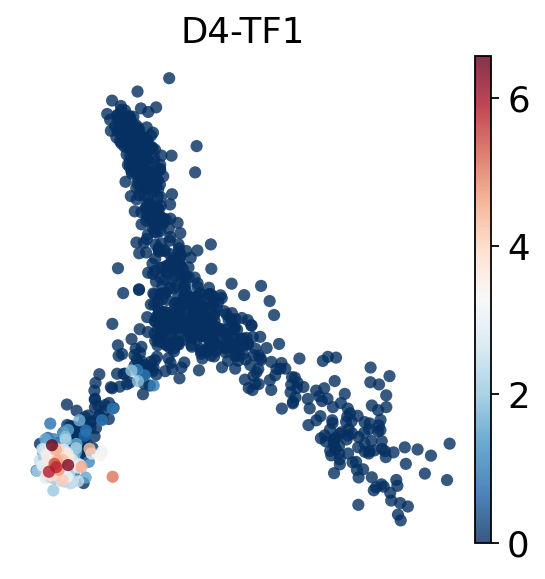

In [14]:
sc.pl.embedding(adata, basis='pca', color=['C5-TF1'],frameon=False,cmap='RdBu_r',alpha=0.8)
sc.pl.embedding(adata, basis='pca', color=['D4-TF1'],frameon=False,cmap='RdBu_r',alpha=0.8)

The stochastic trajectories can be visualized using the **FateCompass** function `umap_plot_sim_cell`. This will provide the trajectory of a given simulated cell. 

In [15]:
mycell = adata.uns['states'][:,9]

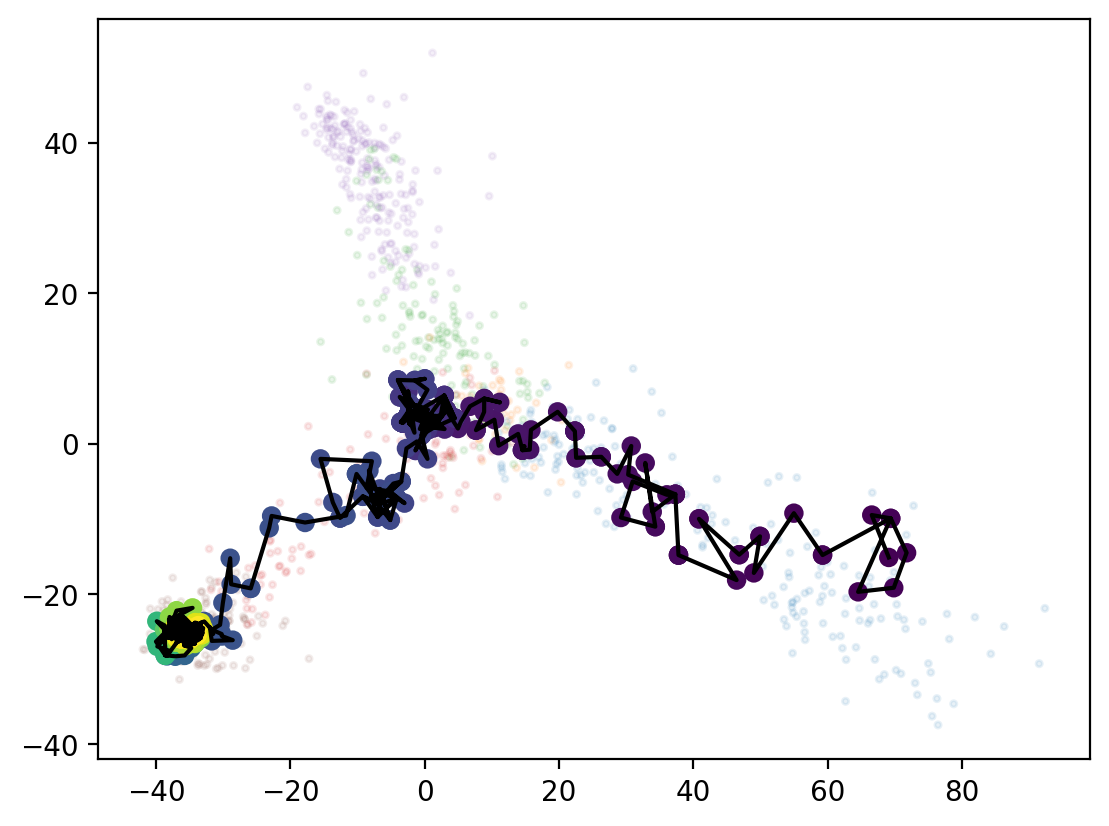

In [16]:
from fatecompass import plot_sim_cell
plot_sim_cell(adata, 'pca', mycell, color = 'clusters')

In [17]:
from fatecompass import fate_probabilities
fate_probabilities(adata, cell_types_key='clusters')

In [18]:
adata.obs['fate_pbbs_C'] = adata.uns['fate_pbbs']['sEndC']
adata.obs['fate_pbbs_D'] = adata.uns['fate_pbbs']['sEndD']

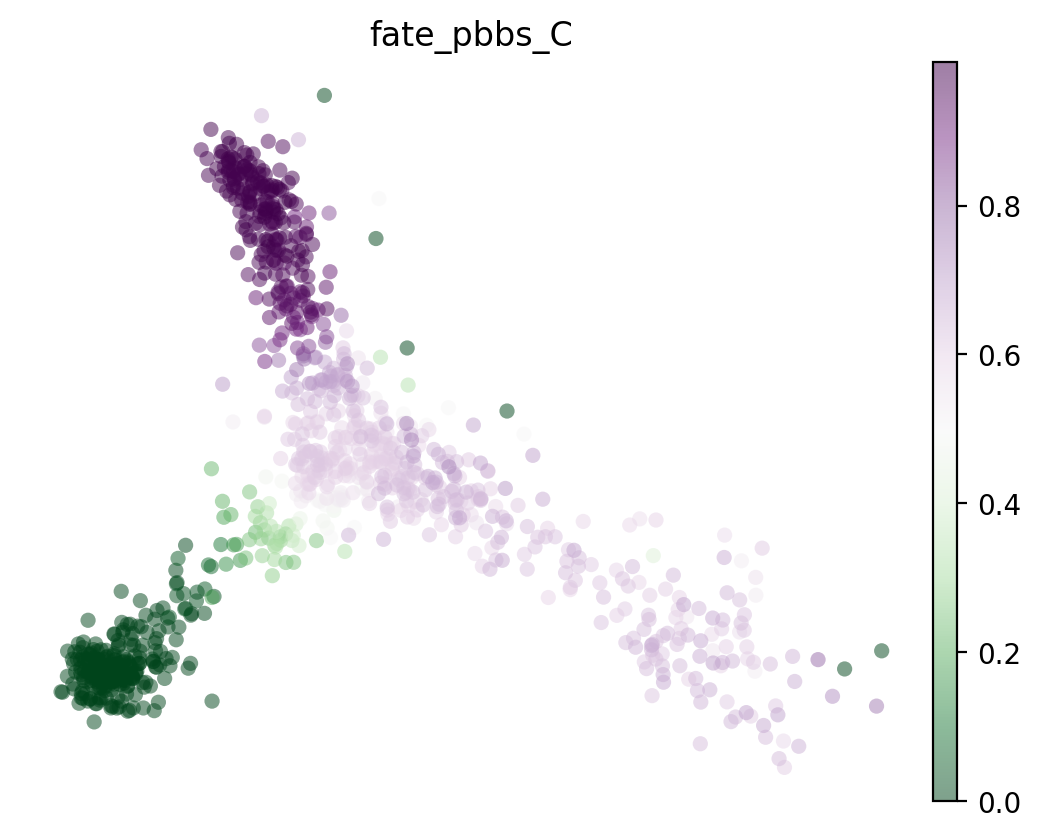

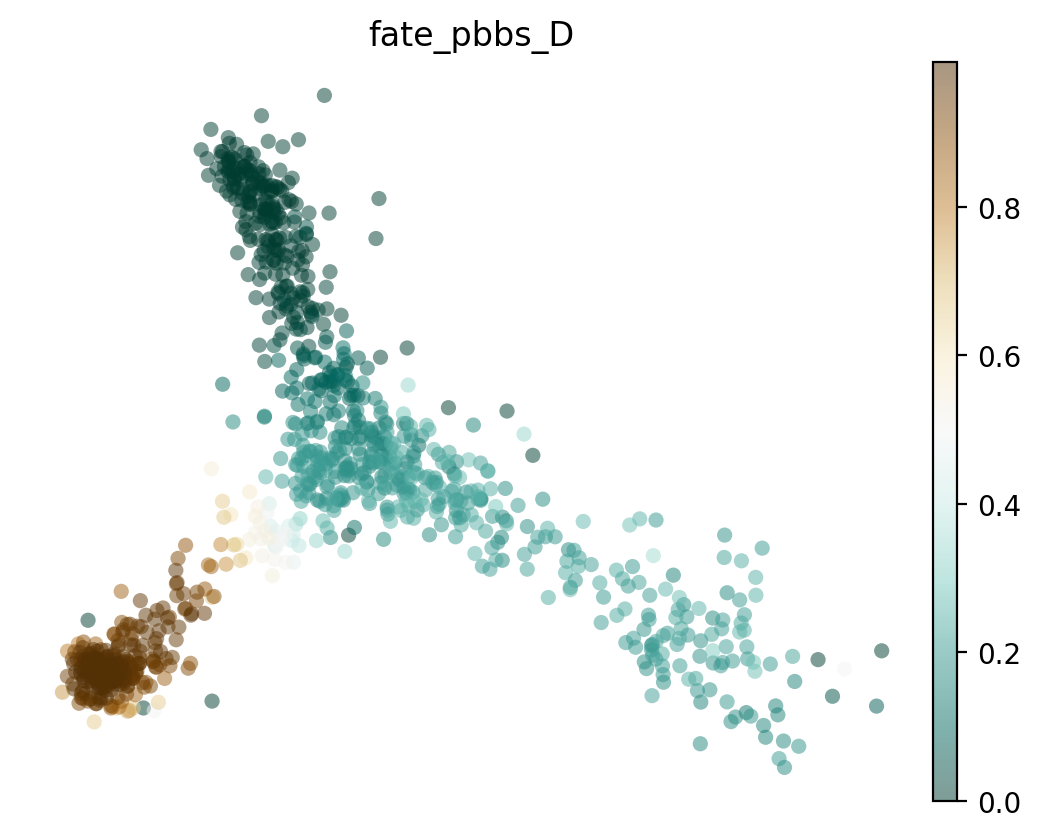

In [19]:
sc.pl.embedding(adata, basis='pca', color=['fate_pbbs_C'],frameon=False,cmap='PRGn_r',alpha=0.5)
sc.pl.embedding(adata, basis='pca', color=['fate_pbbs_D'],frameon=False,cmap='BrBG_r',alpha=0.5)

In [ ]:
from fatecompass import plot_fate_pbb
plot_fate_pbb(adata, basis='pca', color='sEndC')#sEndD

In [ ]:
plot_fate_pbb(adata, basis='pca', color='sEndD')#

### TF activity estimation using a linear model of gene regulation 

The FateCompass function `tf_activities` fits TF activities from the gene expression data using the following linear model of gene regulation:  

\begin{equation}
E_{gc} = \sum_f(N_{gf} * A_{fc}) + noise     
\end{equation}

where $E_{gc}$ is the gene expression matrix, $N_{gf}$ is the binding sites matrix –each entry represents the probability of binding of the TF $f$ in the promoter region of the gene $g$–, and $A_{fc}$ is the TF activity matrix. To account for the noise, the function implements a data diffusion regularization, where the main assumption is that the activity of similar cells should be similar. Then, the learned activities are diffused in the nearest neighbor graph. The diffusion time is fitted using a cross-validation scheme. Finally, the distribution of the TF activities is learned using a bootstrapping strategy.  
<br>

The inputs for the `tf_activities` function are: 
1. **adata**: pre-proccessed and log normalized anndata object
2. **bs**: binding sites matrix. Data frame with rows equal genes and columns equal TFs. 
3. **tolerance**: minimum difference between the test and training datasets used in the cross-validation scheme. Default 1e-2.  

The output are the TF activies and their distribution ('tf_activities' and 'tf_activities_distribution') stored in the anndata object: `adata.uns`  


In [20]:
from fatecompass import tf_activities

tf_activities(adata, bs, tolerance = 4)

Number of cells: 1000
Number of genes: 1035
Number of motifs: 130
Normalized binding site matrix [genes x motifs]: (1035, 130)
Cell- and Gene- Normalized expression matrix [cells x genes]: (1000, 1035)

Initializing cross-validation scheme to fit the value of t for data diffusion regularization

Diffusion time:  0 	 Residual:  102.64516050750012
Diffusion time:  1 	 Residual:  102.64516050750012
Diffusion time:  2 	 Residual:  9.263902473315571

Initializing bootstrapping to build the distribution of the estimate for the TF activities.

sample	 0
sample	 10
sample	 20
sample	 30
sample	 40
sample	 50
sample	 60
sample	 70
sample	 80
sample	 90

Finished -->added
 'tf_activities' and 'tf_activities_distribution', TF activities regularized (adata.uns)



The TF activities can be visualized using the basic plotting functions of scanpy. For doing that, add to `adata.obs` the value of the TF activities you wish to visualize.  

To check the complete list of TF family names run: `list(bs.columns)`

In [21]:
adata.obs['C5-TF1_act'] = adata.uns['tf_activities'].loc[:,'C5-TF1']
adata.obs['D4-TF1_act'] = adata.uns['tf_activities'].loc[:,'D4-TF1']

In [22]:
sc.set_figure_params(scanpy=True, fontsize=16)

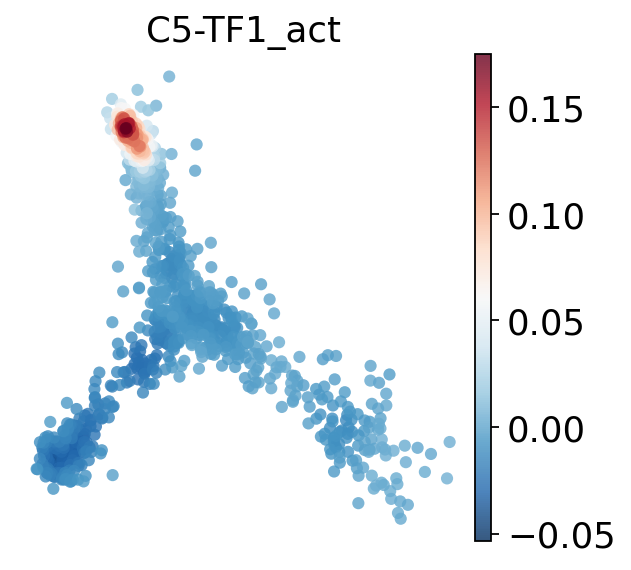

In [23]:
sc.pl.embedding(adata, basis='pca',color=['C5-TF1_act'], frameon=False, cmap='RdBu_r',alpha=0.8)

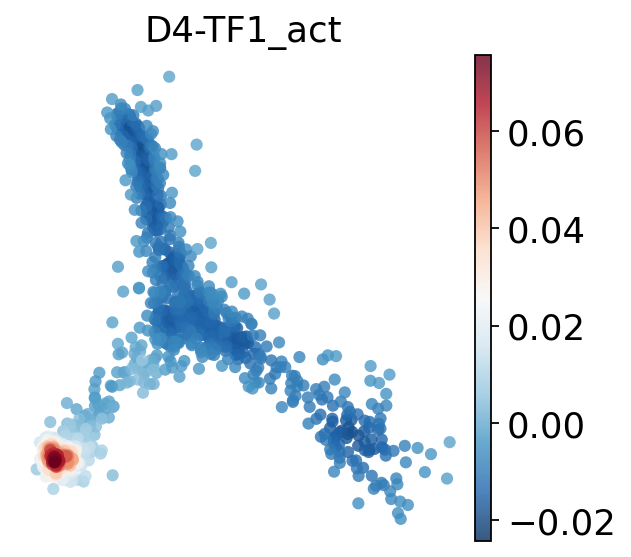

In [24]:
sc.pl.embedding(adata, basis='pca',color=['D4-TF1_act'], frameon=False, cmap='RdBu_r',alpha=0.8)

The activity of **all** the TFs can be visualized using `clustermap` from the *seaborn* library as follows:

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df=adata.uns['tf_activities']
df['clusters']=adata.obs['clusters'].values

clusters = df['clusters']
keys = adata.obs['clusters'].cat.categories
values = adata.uns['clusters_colors']

lut1 = {keys[i]: values[i] for i in range(len(keys))}
col_colors1 = clusters.map(lut1)

df = df.drop(['clusters'], axis=1)

In [ ]:
sns.set(font_scale=1.0)
g=sns.clustermap(df.T,col_cluster=True,row_cluster=True, col_colors=col_colors1,
                 cmap='RdBu_r',z_score=0,yticklabels=True,figsize=(10, 10))
ax = g.ax_heatmap
g.cax.set_visible(False)
g.ax_cbar.set_visible(True,)
ax.set_xticks([])
ax.set_xticklabels([])
plt.show()

### Average gene expression and activity profiles over stochastic trajectories

The **FateCompass** function `avg_profiles_over_trajectories` uses the stochactic tracjectories previously generated (stored in `adata.uns['states']`) to approximate the expected value of the mean and the standard error of the mean (sem).  

The inputs for `avg_profiles_over_trajectories` are:  
1. **adata**: pre-proccessed and log normalized anndata object.  
2. **cell_types_key**: key of the observations clustering to consider.  

The outputs are the **mean** and **sem** of the gene expression ('mean_E', and 'sem_E') and activity ('mean_A', and 'sem_S') profiles stored in the anndata object: `adata.uns`. Also, it returns the number of trajectories that end up in a given fate (`adata.uns['num_trajectories']`). 

In [25]:
from fatecompass import avg_profiles_over_trajectories
avg_profiles_over_trajectories(adata, cell_types_key='clusters')
# ~7min

sim cell	 0
sim cell	 100
sim cell	 200
sim cell	 300
sim cell	 400
sim cell	 500
sim cell	 600
sim cell	 700
sim cell	 800
sim cell	 900

Finished --> added
 'mean_E' and 'sem_E', average gene expression profiles over trajectories (adata.uns)
 'mean_A' and 'sem_A', average TF activity profiles over trajectories (adata.uns)



The average gene expression and activity profiles can be visualized over the stochastic trajectories using the **FateCompass** function `plot_trajectory`.  

The inputs for the `plot_trajectory` are:  
1. **adata**: pre-proccessed and log normalized anndata object. 
2. **mode**: which average profile to plot, it can be **'mRNA'** or **'activity'**.  
3. **variable**: **gene** (in 'mRNA' mode) or **motif** (in 'activity' mode) for which you want to plot the trajectory.  
4. **cell_types_key**: key of the observations clustering to consider.  
5. **trajectory**: over which trajectory you wish to plot the profile of the variable of interest. It must be a key from cell_types_key.  


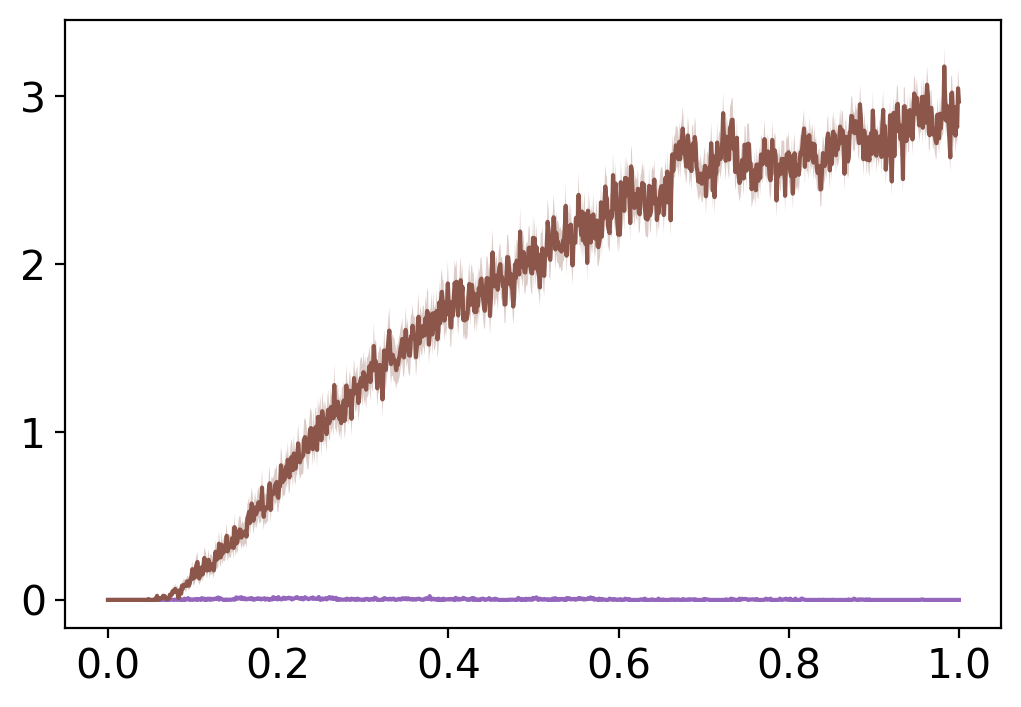

In [32]:
from fatecompass import plot_trajectory
plot_trajectory(adata, mode='mRNA' ,variable=['B14-TF1'], 
                cell_types_key='clusters', trajectory=['sEndC','sEndD'])

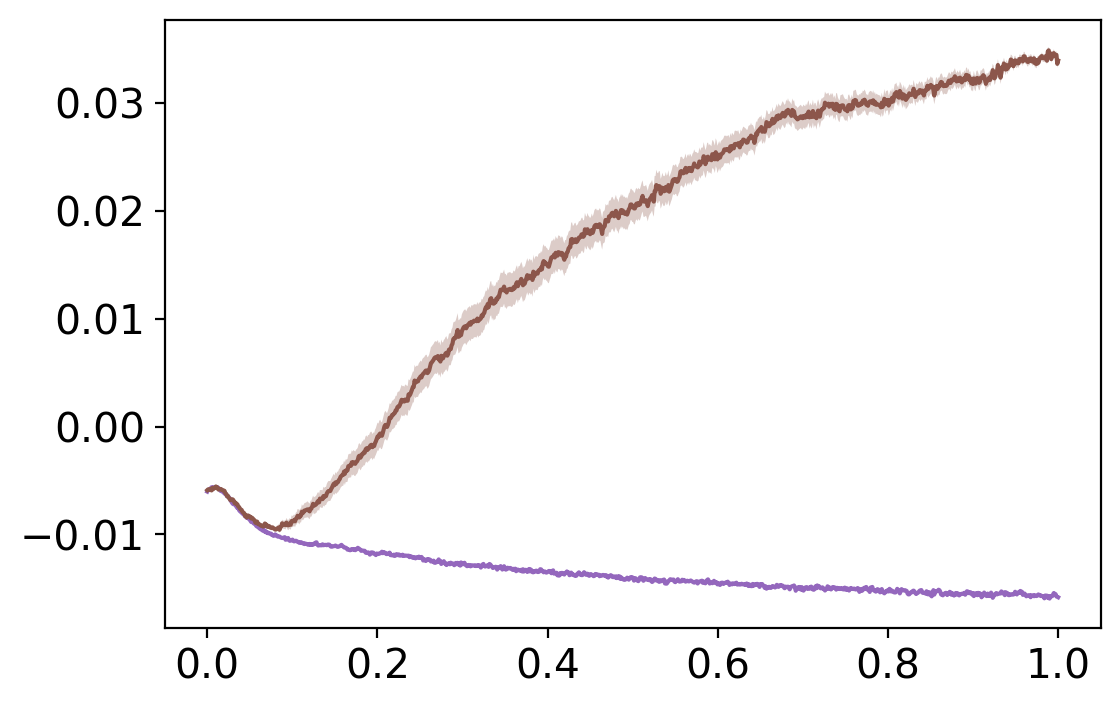

In [33]:
plot_trajectory(adata, mode='activity' ,variable=['B14-TF1'], 
                cell_types_key='clusters', trajectory=['sEndC','sEndD'])

### Differential TF activity analysis  

The **FateCompass** function `differential_tf_activity` computes three criteria to guide the identification of lineage-specific regulators. The criteria are:  

1. **z-score**: it can be interpreted as the number of standard deviations that the activity of a TF is away from its average of zero corrected by the precision of the estimation (a.k.a. error bar).  
2. **Variability over time**: it can be interpreted ad the rate of change of the TF activity over simulated time. FateCompass gets a proxy of this by computing the standard deviation of the TF activity over the stochastic trajectories.  
3. **Dynamic correlation**: this is the cross-correlation between the TF activity and the average gene expression profile of the TF transcript. 

The inputs for `differential_tf_activity` are:  
1. **adata**: pre-proccessed and log normalized anndata object.  
2. **cell_types_key**: key of the observations clustering to consider.  

The outputs are the 'z_score', 'std_tf_time', 'cross_corr' and 'time_lags' stored in the anndata object: `adata.uns`.

In [ ]:
from fatecompass import differential_tf_activity
differential_tf_activity(adata, 'clusters')

To identify lineage-specific regulators we suggest to **explore the density distribution of the three criteria described above**; this exploration will guide the setting of thresholds. Below we provide examples of how to do the exploration.  

The **FateCompass** function `ksdensity_fatecompass` allows to explore two criteria: z-score and variability over time:  

1. The **z-score** is computed TF-wise, by plotting the density distribution we can visualize what is the most common value and the range. We suggest to set a threshold for the z-score higher than or equal to the most common value.  
2. The **variability over time** is computed TF-wise for ***every differentiation trajectory**. Similarly to the z-score, we can visualize the density distribution for the different trajectories. We suggest to set a threshold for the variability over time higher than or equal to the mean of the most common values for the different trajectories.  

The inputs for `ksdensity_fatecompass` are:  
1. **adata**: pre-proccessed and log normalized anndata object. 
2. **criteria**: criteria to plot `['z_score','std_tf_time']`.  
3. **cell_types_key**: key of the observations clustering to consider. 
4. **trajectory**: for which trajectories you wish to plot the density distribution. It must be a key from cell_types_key.  

In [ ]:
from fatecompass import ksdensity_fatecompass

ksdensity_fatecompass(adata, criterion=['std_tf_time','z_score'], cell_types_key='clusters', 
                      trajectory=['sEndC','sEndD'])

In [ ]:
thresholds = {'variability': 0.006, 'z_score': 0.2, 'correlation': 0.5}
thresholds

In [ ]:
from fatecompass import get_df_differential_tf_activity
df = get_df_differential_tf_activity(adata,fates=['sEndC','sEndD'], 
                                     thresholds=thresholds)
df

In [ ]:
df.to_csv('output/dyngen/dyngen_potential_k_30.txt', header=True, index=True, sep='\t')

In [ ]:
adata.obs['clusters'].cat.categories

In [ ]:
adata.uns['clusters_colors']

In [ ]:
scv.settings.set_figure_params("scvelo",fontsize=16)
x1 = np.linspace(-1,1,(adata.uns['time_lags']['sEndC']['B11-TF1']).shape[0])
y1 = adata.uns['cross_corr']['sEndC']['B11-TF1']
plt.plot(x1,y1,c='#9467bd')
x2 = np.linspace(-1,1,(adata.uns['time_lags']['sEndD']['B11-TF1']).shape[0])
y2 = adata.uns['cross_corr']['sEndD']['B11-TF1']
plt.plot(x2,y2,c='#8c564b')